#ЛР №7

Основные понятия ООП. Наследование. Полиморфизм.

#Основное задание




Написать базовый класс BaseProcessing, который предоставляет интерфейс для обработки данных (сигналы и изображения).

В классе BaseProcessing реализовать следующие абстрактные методы:

**Интерфейс BaseProcessing**

* `_filtering()` — осуществляет фильтрацию (абстрактный метод).
* `visualize()` — визуализирует сигнал/изображение (абстрактный метод).
* `get_shape()` — возвращает размерность (абстрактный метод).
* `feature_extraction()` — возвращает вектор признаков (абстрактный метод).


Класс SignalProcessing наследует BaseProcessing и переопределяет его методы

**Интерфейс SignalProcessing** (код для реализации отдельных методов ниже)

* _конструктор_ — принимает на вход путь к файлу и создает соответствующие поля
* `_filtering(signal)` — осуществляет фильтрацию сигнала (возвращает отфильтрованный сигнал).
* `visualize()` — визуализирует сигнал.
* `get_shape()` — возвращает длину сигнала.
* `_signal_find_peaks(signal, find_peaks_parametres)` — находит точки максимума сигнала и возвращает их в виде списка.
* `_calculate_RR_intervals()` — производит расчет длительности RR интервалов (попарных расстояний между пиками) и возвращает длины RR интервалов в виде списка.
В этом методе вызываются методы _filtering и _signal_find_peak.
* `feature_extraction()` — возвращает статистические характеристики RR интервалов на записи ECG - среднее, std, min, max (в виде списка - вектор признаков). В этом методе вызывается метод _calculate_RR_intervals.

Класс ImageProcessing наследует BaseProcessing и переопределяет его методы

**Интерфейс ImageProcessing**

* _конструктор_ — принимает на вход путь к файлу и создает соответствующие поля
* `_filtering(image)` — применяет фильтр Гаусса к изображению (возвращает отфильтрованное изображение).
* `visualize()` — визуализирует изображение.
* `get_shape()` — возвращает размерность изображения.
* `_create_gabor_filter(parameters)` — создает и возвращает фильтр Габора с заданными параметрами.
* `feature_extraction()` — применяет _filtering() к изображению, считает признаки с _create_gabor_filter(parameters) и возвращает вектор признаков: среднее и дисперсию по изображению.

*можно добавить свои методы


Изображение и сигнал:
https://drive.google.com/drive/folders/1c5jKaURno_RHJsrfb4cnbdq19vs0rOVk?usp=sharing

# Инициализация

In [1]:
!pip install heartpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.9 MB/s eta 0:00:00


In [2]:
# Необходимые модули и функции
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import heartpy as hp
from scipy.signal import find_peaks
from abc import ABC, abstractmethod

<ipython-input-2-4eb759daf52d>:6: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [3]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Классы

## Base

In [ ]:
class BaseProcessing(ABC):
  @abstractmethod
  def _filtering(self):
    pass

  @abstractmethod
  def visualize(self):
    pass

  @abstractmethod
  def get_shape(self):
    pass

  @abstractmethod
  def feature_extraction(self):
    pass

## Signal

In [ ]:
class SignalProcessing(BaseProcessing):
  def __init__(self, path):
    self.signal = pd.read_csv(path)['MLII']
    self.parameters = {
         'filtration_parametres': {
             'cutoff': [0.75, 3.5],
             'sample_rate':100,
             'order': 3,
             'filtertype':'bandpass'
             },
         'peaks_parametres': {
             'height':20
             }
         }

  @staticmethod
  def _filtering(signal):
    filtered = hp.filter_signal(signal, cutoff=[0.75, 3.5], sample_rate=100, order=3, filtertype='bandpass')
    return filtered

  @staticmethod
  def _signal_find_peaks(signal, peaks_parametres):
    peaks, _ = find_peaks(signal, **peaks_parametres)
    return peaks

  def visualize(self):
    plt.plot(self.signal)
    plt.show()

  def plot_filtered_signal(self):
    plt.plot(self._filtering(self.signal))
    plt.show()

  def plot_peaks_signal(self):
    filtered = self._filtering(self.signal)
    peaks = self._signal_find_peaks(filtered, self.parameters['peaks_parametres'])
    plt.plot(peaks, filtered[peaks])
    plt.show()

  def get_shape(self):
    return self.signal.shape[0]

  def _calculate_RR_intervals(self):
    filtered = self._filtering(self.signal)
    rr = self._signal_find_peaks(filtered, self.parameters['peaks_parametres'])
    calc_rr = []
    for i in range (1, len(rr)):
      calc_rr.append(rr[i]-rr[i-1])
    return calc_rr

  def feature_extraction(self):
    calc_rr = self._calculate_RR_intervals()
    stat = []
    stat.append(np.mean(calc_rr))
    stat.append(np.std(calc_rr))
    stat.append(np.min(calc_rr))
    stat.append(np.max(calc_rr))
    return stat

## Image

In [ ]:
class ImageProcessing(BaseProcessing):
  def __init__(self, path):
    self.image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    self.gabor_parameters = {
             'frequency': 0.25,
             'theta': np.pi,
             'sigma_x': 1,
             'sigma_y':1
             }

  @staticmethod
  def _filtering(image):
    image_filtered = ndi.gaussian_filter(image, .5)
    return image_filtered

  @staticmethod
  def create_gabor_filter(parameters):
    kernel = np.real(gabor_kernel(**parameters))
    return kernel

  def visualize(self):
    plt.imshow(self.image, cmap='gray')
    plt.show()

  def plot_gabor_filter(self):
    kernel = self.create_gabor_filter(self.gabor_parameters)
    plt.imshow(kernel, cmap='gray')
    plt.show()

  def plot_filtered_image(self):
    filtered = self._filtering(self.image)
    plt.imshow(filtered, cmap='gray')
    plt.show()

  def plot_gabor_filtered_image(self):
    filtered = self._filtering(self.image)
    kernel = self.create_gabor_filter(self.gabor_parameters)
    conv = ndi.convolve(filtered, kernel, mode='wrap')
    plt.imshow(conv, cmap='gray')
    plt.show()

  def get_shape(self):
    return self.image.shape

  def feature_extraction(self):
    filtered = self._filtering(self.image)
    kernel = self.create_gabor_filter(self.gabor_parameters)
    conv = ndi.convolve(filtered, kernel, mode='wrap')
    feats = [conv.mean(), conv.var()]
    return feats

# Основной код

Длина сигнала = 20000


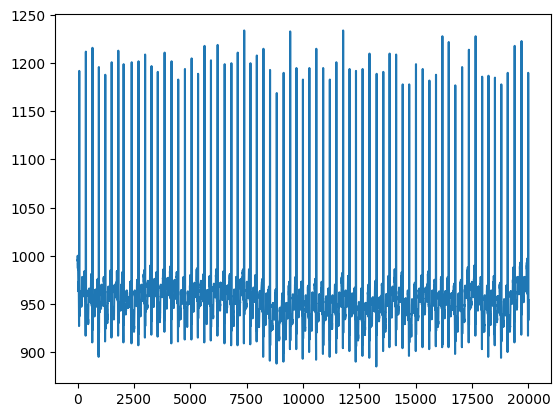

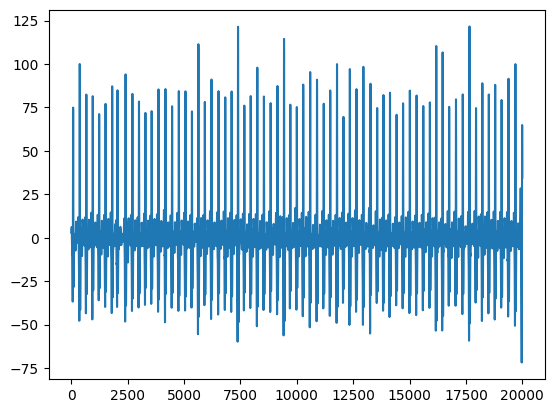

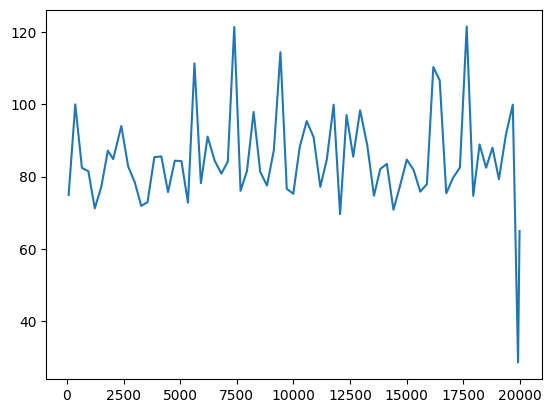

Вектор признаков: [288.6231884057971, 31.077323597890175, 66, 358]
Размерность изображения = (493, 600)


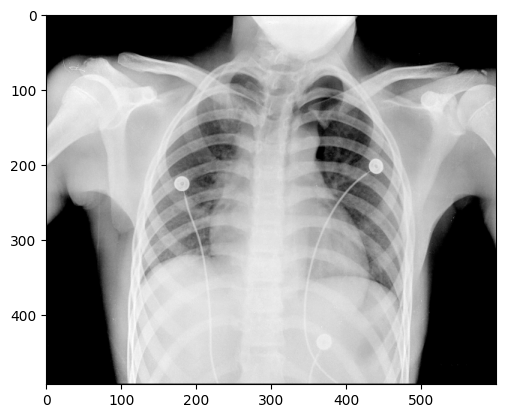

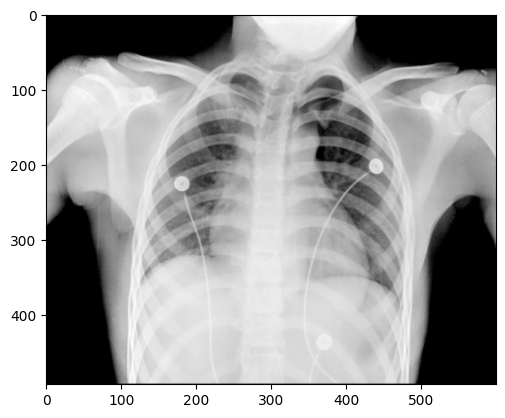

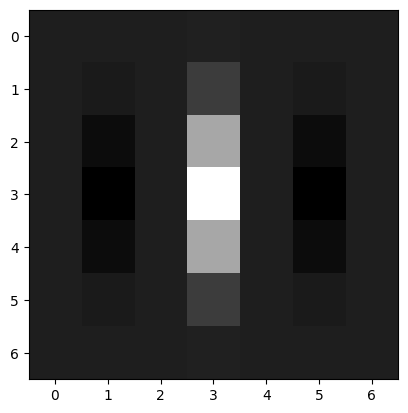

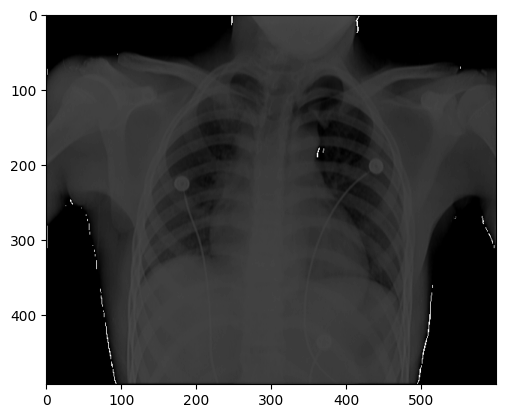

Вектор признаков: [41.113566599053414, 670.1179849805205]


In [ ]:
path_sig = '/content/drive/MyDrive/Experiments/LR_7/ecg.csv'

sig = SignalProcessing(path_sig)
print('Длина сигнала =', sig.get_shape())
sig.visualize()
sig.plot_filtered_signal()
sig.plot_peaks_signal()
print('Вектор признаков:', sig.feature_extraction())

path_im = '/content/drive/MyDrive/Experiments/LR_7/chest-xray.tif'

im  = ImageProcessing(path_im)
print('Размерность изображения =', im.get_shape())
im.visualize()
im.plot_filtered_image()
im.plot_gabor_filter()
im.plot_gabor_filtered_image()
print('Вектор признаков:', im.feature_extraction())

###Для сигнала

In [ ]:
# Загрузка сигнала из .csv файла с pandas
df = pd.read_csv('path_to_ecg/ecg.csv')
plt.plot(df['MLII'])
plt.show()

In [ ]:
# Размерность
df['MLII'].shape

In [ ]:
# Фильтрация сигнала с библиотекой heartpy
filtered = hp.filter_signal(df['MLII'], cutoff=[0.75, 3.5], sample_rate=100, order=3, filtertype='bandpass')
plt.plot(filtered)
plt.show()

In [ ]:
# Поиск точек максимума с библиотекой scipy
peaks, _ = find_peaks(filtered, height=20)
plt.plot(filtered)
plt.plot(peaks, filtered[peaks], "o")
plt.show()

###Для изображения

In [ ]:
# Создание фильтра Габора
frequency = 0.25
theta = np.pi
sigma = 1
kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
plt.imshow(kernel, cmap='gray')
plt.show()

In [ ]:
# Чтение изображения
image = cv2.imread('path_to_image', cv2.IMREAD_GRAYSCALE)
# Применение фильтра Гаусса к изображению
image_filtered = ndi.gaussian_filter(image, .5)

In [ ]:
# Размерность изображения
image.shape

In [ ]:
# Свертка изображения с фильтром Габора
conv = ndi.convolve(image_filtered, kernel, mode='wrap')
plt.imshow(conv, cmap='gray')
plt.show()

In [ ]:
# Расчет вектора признаков изображения
feats = [conv.mean(), conv.var()]
feats

#Задача * "Классификатор"

В классе BaseProcessing реализовать метод:
* `get_predict(features, etalons_features)` — метод, в котором осуществляется классификация на основе расчета Евклидова расстояния между features изображения или сигнала и эталонными значениями признаков (etalons_features) каждого класса изображений или сигналов. Классификация осуществляется следующим образом: полученные Евклидовы расстояния ранжируются в порядке возрастания. Чем меньше Евклидово расстояние, тем более похожим на эталонное изображение считается наше изображение. Выбирается индекс соответствующих эталонных признаков, которые и являются номером класса. Эталонных класса 2, т.е. возвращается 0 или 1, т.е. класс к которому относится изображение/сигнал.

Классы SignalProcessing и ImageProcessing наследуют реализованный метод get_predict.

Продемонстрировать вызов метода в классах

Эталонные признаки (etalons_features) подаются в формате списка:
[[1, 8], [5, 0.5]] (тогда класс вернуть по индексу) или в формате словаря [{'features': [1, 8], 'class': 0}, {'features': [5, 0.5], 'class': 1}]

#Задача ***  "Словарь-директория"



Нужно написать класс, который полностью повторяет интерфейс обычного `dict`,
но хранит все данные на диске в указанной директории. Причем все ключи — это файлы,
а значения — их содержимое. Значения — юникодные строки, при попытке записать что-то другое,
просто записывать строковое представление.

Кеша быть не должно, все изменения на диске должны мгновенно отражаться в объекте.

Пример
------

```python
d = DirDict('/tmp/dirdict')
d['lang'] = 'Python\n'
```

```bash
$ cat /tmp/dirdict/lang
Python
```